In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import random
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

In [69]:
# Define paths
train_dir = "/Users/anshmadan/Coding/IML Final Project/Birds_25/train"
valtest_dir = "/Users/anshmadan/Coding/IML Final Project/Birds_25/valid"

# Set parameters
image_size = (256, 256)
batch_size = 32
seed = 123

In [76]:
# Load the training dataset
train = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    validation_split=None, # Not using a split here since this is all training data
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

# Load the validation dataset (80% of what's in 'valid')
val = tf.keras.utils.image_dataset_from_directory(
    directory=valtest_dir,
    validation_split=0.2,       # 20% held out for test
    subset="training",          # 80% of valid data
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

# Load the test dataset (20% of what's in 'valid')
test = tf.keras.utils.image_dataset_from_directory(
    directory=valtest_dir,
    validation_split=0.2,
    subset="validation",        # the remaining 20%
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

Found 30000 files belonging to 25 classes.
Found 7500 files belonging to 25 classes.
Using 6000 files for training.
Found 7500 files belonging to 25 classes.
Using 1500 files for validation.


In [77]:
# Normalize the data by mapping images to [0,1] range
train = train.map(lambda x,y: (x/255.0, y))
val = val.map(lambda x,y: (x/255.0, y))
test = test.map(lambda x,y: (x/255.0, y))

In [4]:
data_dir = 'data'

In [15]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 30000 files belonging to 25 classes.


In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

PRE PROCESS DATA

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
scaled_iterator = data.as_numpy_iterator()

In [20]:
batch = scaled_iterator.next()

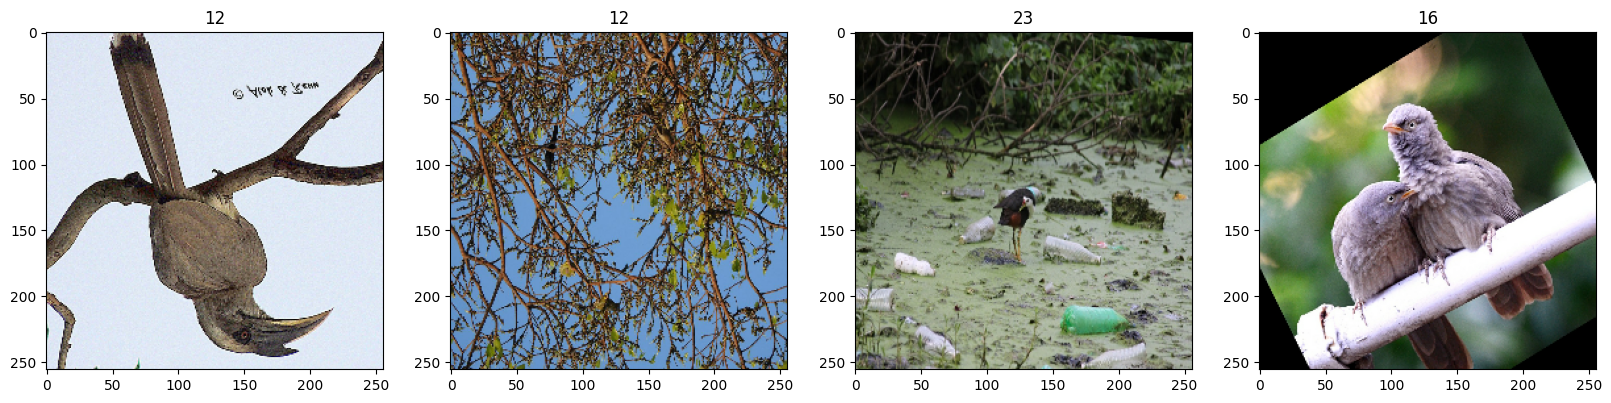

In [79]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]) :
    ax[idx]. imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [22]:
len(data)

938

In [23]:
train_size = int(len(data)*.7)
val_size = int(len (data)*.2)+1
test_size = int(len(data)*.1)+1

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [25]:
len(test)

94

Deep Model

In [80]:
from tensorflow.keras import layers, models

model = models.Sequential()

# Block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))  # Slightly increased dropout

# Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))  # Further increased dropout

# Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Block 4
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(25, activation='softmax'))  # Output layer for 25 classes


/Users/anshmadan/Coding/IML Final Project/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,04

 Total params: 34,743,993 (132.54 MB)

 Trainable params: 34,742,009 (132.53 MB)

 Non-trainable params: 1,984 (7.75 KB)

TRAIN THE MODEL


In [83]:
logdir = 'logs'

In [84]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [85]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)


In [86]:
hist = model.fit(
        train, 
        epochs=20, 
        validation_data=val, 
        callbacks=[tensorboard_callback, lr_schedule, early_stop]
    )

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 843s 889ms/step - accuracy: 0.1302 - loss: 3.3292 - val_accuracy: 0.0677 - val_loss: 59.5403 - learning_rate: 1.0000e-04
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 617s 657ms/step - accuracy: 0.2982 - loss: 2.4071 - val_accuracy: 0.1045 - val_loss: 17.6768 - learning_rate: 1.0000e-04
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 589s 627ms/step - accuracy: 0.4146 - loss: 1.9741 - val_accuracy: 0.2998 - val_loss: 5.8556 - learning_rate: 1.0000e-04
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 584s 622ms/step - accuracy: 0.4823 - loss: 1.7396 - val_accuracy: 0.4700 - val_loss: 2.2410 - learning_rate: 1.0000e-04
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 585s 623ms/step - accuracy: 0.5517 - loss: 1.4724 - val_accuracy: 0.5210 - val_loss: 1.7901 - learning_rate: 1.0000e-04
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 585s 622ms/step - accuracy: 0.6231 - loss: 1.2278 - val_accuracy: 0.5788 - val_loss: 1.5232 - learning_rate: 1.0000e-04
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━

Evaluating performance

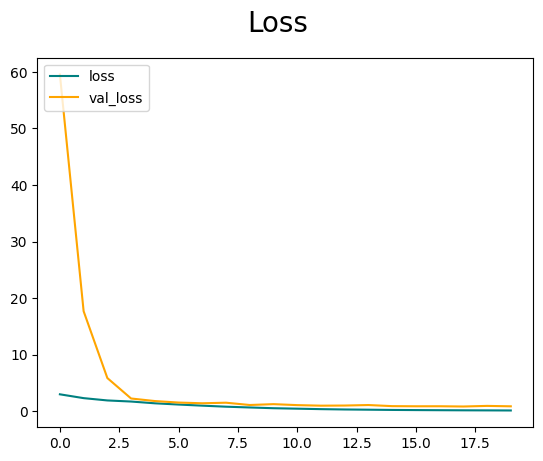

In [87]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend (loc="upper left")
plt.show()

In [92]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [93]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy

acc = SparseCategoricalAccuracy()


In [94]:
acc.update_state(y, yhat)

In [95]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-12-07 11:16:34.334841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [96]:
print(f'Accuracy: {acc.result().numpy()}')

Accuracy: 0.7777044773101807


In [97]:
model.save_weights('(11).weights.h5')  # Save weights to an HDF5 file

In [ ]:
model.save('(11.keras')